In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from random import sample
import seaborn as sns

from statsmodels import regression
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

plt.rcParams["figure.figsize"] = (15,7)

<h1> Pairs trading </h1>


In [90]:
# Find their closing prices for the last three years from 2017-01-01 to 2021-01-01.
# Store this in a variable called prices
start = "2016-04-01"
end = "2021-04-01"
samples = ["AM","AR","APA","AROC","BKR","BSM","BP","BPMP","COG","WHD","CPE","CVE","CDEV","CHX","LNG","CQP","CHK","CVX","XEC","CLNE","CNX","CRK","COP","CLR","CEQP","CVI","DCP","DKL","DK","DEN","DVN","FANG","DNOW","ET","DRQ","ENBL","ERF","ENLC","EPD","EOG","EQT","ETRN","XOM","GEL","HAL","HP","HES","HEP","HFC","KMI","KOS","LBRT","MMP","MGY","MRO","MPC","MTDR","MPLX","MUR","NESR","NFG","NOV","NBLX","NS","OAS","OXY","OII","OKE","PTEN","PBF","PDCE","PSX","PSXP","PXD","PAA","PAGP","RRC","RTLR","REGI","RES","SOL","SLB","SHLX","OILY","SM","SWN","SUN","TRGP","FTI","TPL","TGS","WMB","RIG","USAC","VLO","VVV","VET","VNOM","WES","WLL","INT"]
data = yf.download(tickers=samples, start=start, end=end, interval = "1d")
prices = data['Adj Close'].dropna(axis=1)


[*********************100%***********************]  101 of 101 completed


In [91]:
# Uses to coint method to find cointegration for each pair in the sample
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j],pvalue))
    return score_matrix, pvalue_matrix, pairs

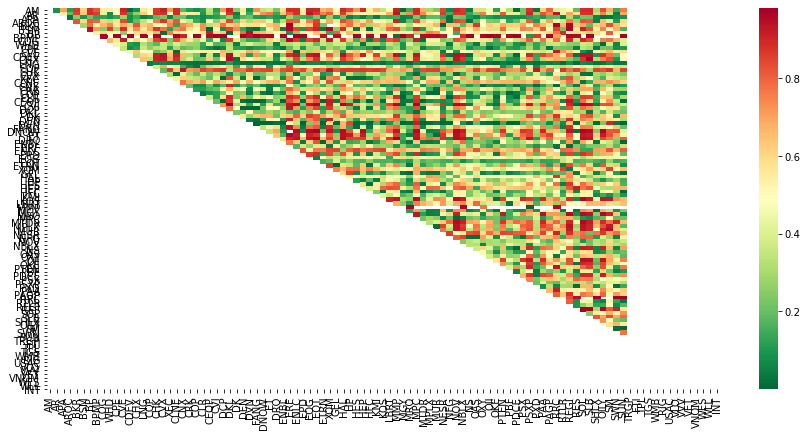

In [92]:
# This might take a minute
scores, pvalues, pairs, = find_cointegrated_pairs(prices)
sns.heatmap(pvalues, xticklabels=samples, yticklabels=samples, cmap='RdYlGn_r' , mask = (pvalues >= 0.98))
plt.show()

In [93]:
best_pairs = [pair for pair in pairs if pair[2]<.001]
#best_pairs

In [94]:
# Set ticker1 and ticker2 to the stocks you've identified.
ticker1 = "ET"# Set ticker1
ticker2 = "HEP"# Set ticker2
S1 = prices[ticker1]
S2 = prices[ticker2]
score, pvalue, _ = coint(S1, S2)
print(pvalue)

ratios = S1 / S2
#ratios.plot(figsize=(15,7))
#plt.axhline(ratios.mean())
#plt.legend(['Price Ratio'])
#plt.show()

6.35076367320244e-06


In [95]:
split_number = round(2/3 * len(ratios))# Insert above number
train = ratios[:split_number]
test = ratios[split_number:]
print(ratios)

Date
2016-04-01    0.211043
2016-04-04    0.201975
2016-04-05    0.198953
2016-04-06    0.207341
2016-04-07    0.214564
                ...   
2021-03-25    0.426843
2021-03-26    0.420467
2021-03-29    0.419753
2021-03-30    0.416086
2021-03-31    0.401884
Length: 1259, dtype: float64


In [96]:
total_profit = 0
for pair in pairs:
    ticker1 = pair[0]
    ticker2 = pair[1]
    total_profit += trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 60)
average_profit = total_profit/len(pairs)
average_profit

280.1123505418289

In [97]:
# Compute the rolling z-score of the ratio using the definition above
# Hint: Use pandas.Series.rolling on your training set. Set center = false

ratios_mavg5 = ratios.rolling('5d',center = False).mean() 
# print(ratios_mavg5)

ratios_mavg60 = ratios.rolling('60d',center = False).mean() 
# print(ratios_mavg60)

std_60 = ratios.rolling('60d',center = False).std()
# print(std_60)

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
print(zscore_60_5)

Date
2016-04-01         NaN
2016-04-04    0.000000
2016-04-05    0.000000
2016-04-06   -0.383368
2016-04-07   -0.166914
                ...   
2021-03-25   -0.786529
2021-03-26   -0.856319
2021-03-29   -1.088183
2021-03-30   -1.248805
2021-03-31   -1.483390
Length: 1259, dtype: float64


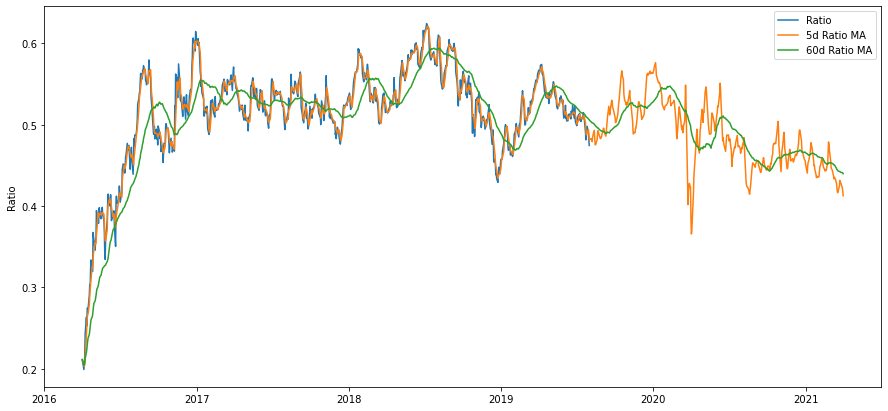

In [98]:
# This plots the moving averages you calculated. Notice how longer windows smoothen out the curves.

plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

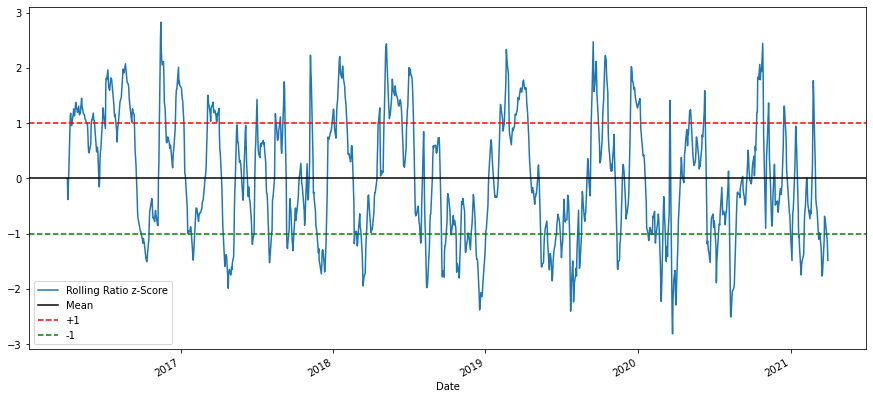

In [99]:
# This plot the rolling z-score of the ratio

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

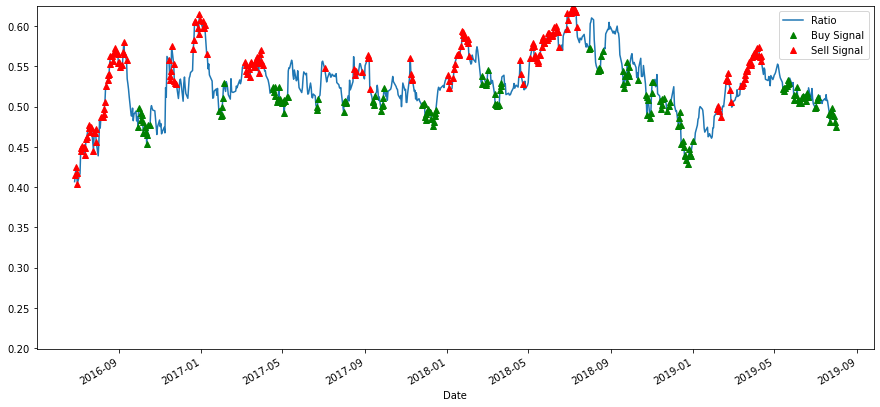

In [100]:
#Generate signals using the previously defined trading strategy

plt.figure(figsize=(15,7))
train[60:].plot()

buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0 
sell[zscore_60_5<1] = 0

buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

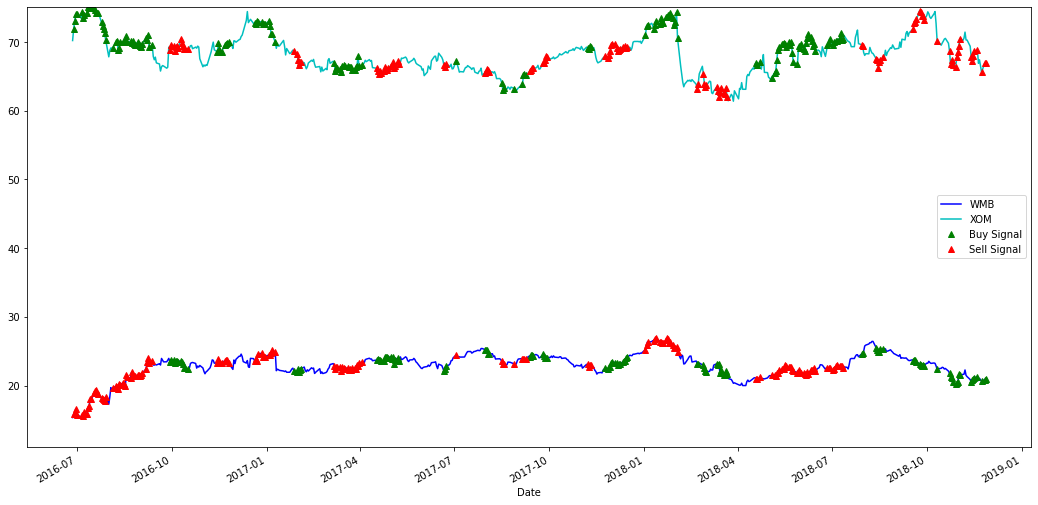

In [101]:
plt.figure(figsize=(18,9))
S1 = prices[ticker1].iloc[:671]
S2 = prices[ticker2].iloc[:671]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend([ticker1,ticker2, 'Buy Signal', 'Sell Signal'])
plt.show()

In [102]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [103]:
trade(prices[ticker1].iloc[:split_number], prices[ticker2].iloc[:split_number], 5, 60)

95.73907407045127

In [104]:
trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 60)

-162.82886596975857

In [105]:
# Check with training data
length_scores = [trade(prices[ticker1].iloc[:split_number], 
                prices[ticker2].iloc[:split_number], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)
print('Money made:', length_scores[best_length])

Best window length: 231
Money made: 464.4215311691509


In [65]:
# Check with testing data
length_scores2 = [trade(prices[ticker1].iloc[split_number:], 
                  prices[ticker2].iloc[split_number:],5, l) 
                  for l in range(255)]

best_length2 = np.argmax(length_scores2)
print ('Best window length:', best_length2)
print('Money made:', length_scores2[best_length2])

Best window length: 54
Money made: 60.019641863112014
